In [1]:
# Import necessary libraries

import os
import gc
import zipfile
import urllib.request
import json
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets.folder import ImageFolder
from torch.amp import autocast, GradScaler

from transformers import BertTokenizer, BertModel
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from tqdm import tqdm


import urllib.request
def clear_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

def get_device():
    """Get the best available device with optimized settings"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.set_per_process_memory_fraction(0.8)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.set_default_dtype(torch.float32)
        clear_memory()
    else:
        device = torch.device('cpu')
    torch.set_default_device(device)
    return device

clear_memory()


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters and configurations

class CFG:
    seed = 42
    n_epochs = 15
    batch_size = 64
    lr = 1e-4
    wd = 1e-4
    lrd_step = 10
    lrd_gamma = 0.8
    early_stop = True
    use_amp = True

    train_split = 0.7
    val_split = 0.1
    test_split = 0.2
    maxnorm = 1.0
    hflipP = 0.5
    rot_deg = 10
    patience = 2

torch.manual_seed(CFG.seed)
np.random.seed(CFG.seed)

In [3]:
# Download and unzip the images

data_folder = os.path.join(os.getcwd(), "data")
os.makedirs(data_folder, exist_ok=True)
img_path = os.path.join(data_folder, "images.zip")

if not os.path.exists(img_path):
    img_url = "https://data.mendeley.com/public-files/datasets/rxxch9vw59/files/220ffc5a-8645-4c0b-bd1b-97188836ed3b/file_downloaded"
    req = urllib.request.Request(img_url, headers={"User-Agent": "Mozilla/5.0"})
    with urllib.request.urlopen(req) as response, open(img_path, 'wb') as out_file:
        out_file.write(response.read())
    print(f"Downloaded {img_path}")
else:
    print(f"File {img_path} already exists.")

images_folder = os.path.join(data_folder, "images")
os.makedirs(images_folder, exist_ok=True)

if not os.path.exists(images_folder):
    with zipfile.ZipFile(img_path, 'r') as zip_ref:
        zip_ref.extractall(data_folder)
    print(f"Unzipped {img_path} to {images_folder}")
else:
    print(f"Images already unzipped in {images_folder}")

File c:\Users\shayo\OneDrive\Documents\ImageRetrieval-CNN-BERT\data\images.zip already exists.
Images already unzipped in c:\Users\shayo\OneDrive\Documents\ImageRetrieval-CNN-BERT\data\images


In [4]:
# Custom Image Dataset

class ImgFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, filename) 
            for filename in os.listdir(root) 
            if filename.endswith('.png')
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        filename = os.path.basename(img_path)
        if self.transform:
            image = self.transform(image)
        return image, filename

In [5]:
# Load and preprocess the image dataset

basic_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

images_folder = "data/images"
full_dataset = ImgFolder(root=images_folder, transform=basic_transform)
data_loader = DataLoader(full_dataset, batch_size=CFG.batch_size, shuffle=False)

all_images = torch.cat([batch[0] for batch in data_loader], dim=0)
img_mean, img_std = all_images.mean(dim=(0, 2, 3)).numpy(), all_images.std(dim=(0, 2, 3)).numpy()
print(f"Dataset Mean: {img_mean}, Dataset Std: {img_std}")

# Split the dataset into train (70%), validation (10%), and test (20%)
train_size = int(CFG.train_split * len(full_dataset))
val_size = int(CFG.val_split * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

# Data augmentations for training and validation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=CFG.hflipP),
    transforms.RandomRotation(degrees=CFG.rot_deg),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std),
])

val_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=CFG.hflipP),
    transforms.RandomRotation(degrees=CFG.rot_deg),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std),
])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = test_transform

# Create DataLoaders
device = get_device()
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True,
                          generator=torch.Generator(device=device))
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False,
                        generator=torch.Generator(device=device))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False,
                         generator=torch.Generator(device=device))

print(f"Train, Validation, and Test DataLoaders ready.")

Dataset Mean: [0.45674816 0.43342975 0.38905367], Dataset Std: [0.27190068 0.26165867 0.270301  ]
Train size: 6407, Validation size: 915, Test size: 1832
Train, Validation, and Test DataLoaders ready.


In [6]:
# Creating the CNN model

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.encoder = nn.Sequential(
      # Input: 128 x 128 x 3
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
      # Output: 128 x 128 x 32
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
      # Output: 128 x 128 x 32
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Output: 64 x 64 x 32

      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      # Output: 64 x 64 x 64
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      # Output: 64 x 64 x 64
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Output: 32 x 32 x 64

      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      # Output: 32 x 32 x 128
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      # Output: 32 x 32 x 128
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Output: 16 x 16 x 128

      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      # Output: 16 x 16 x 256
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      # Output: 16 x 16 x 256
      nn.ReLU()
    )

    self.dense_layers = nn.Sequential(
      nn.Flatten(),
      # Output: 16*16*256 = 65536 x 1
      nn.Linear(65536, 256),
      # Output: 512 x 1
      nn.ReLU(),
      nn.Linear(256, 256),
      # Output: 256 x 1
      nn.ReLU(),
      nn.Linear(256, 100)
      # Output: 100 x 1
    )
    
    self.features = nn.Sequential(
      nn.Flatten(),
      nn.Linear(65536, 768),
    )
    # Apply Xavier Initialization
    self.init_xavier()

  def init_xavier(self):
    for layer in self.modules():
      if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
          nn.init.constant_(layer.bias, 0)

  def forward(self, x):
    x = self.encoder(x)
    feat = self.features(x)
    x = self.dense_layers(x)
    return x, feat

In [7]:
# Load pre-trained models, set up optimizers, and define loss function

device = get_device()
clear_memory()

load_model = True
cnn_model = CNN()
cnn_model.load_state_dict(torch.load("CNN.pth"))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

criterion = nn.TripletMarginLoss(margin=1.0, p=2)
cnn_optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
bert_optimizer = torch.optim.AdamW(bert_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

cnn_scheduler = StepLR(cnn_optimizer, step_size=CFG.lrd_step, gamma=CFG.lrd_gamma)
bert_scheduler = StepLR(bert_optimizer, step_size=CFG.lrd_step, gamma=CFG.lrd_gamma)
scaler = GradScaler('cuda') if device.type == 'cuda' else None

C:\Users\shayo\AppData\Local\Temp\ipykernel_32636\2132838344.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("CNN.pth"))


In [8]:
# Training loop
cnn_model = cnn_model.to(device)
bert_model = bert_model.to(device)
criterion = criterion.to(device)
train_losses, val_losses = [], []
best_val_loss = float('inf')
cap_path = os.path.join(data_folder, "new_captions.json")
with open(cap_path, 'r', encoding='utf-8') as f:
    json_data = json.load(f)
data = {entry['filename']: entry for entry in json_data}


for epoch in range(CFG.n_epochs):

    # Training phase
    cnn_model.train()
    bert_model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG.n_epochs}", unit="batch")
    for idx, (images, labels) in enumerate(loop): 
        try:
            images = images.to(device)
            positive_captions = [data[f]['eng_caption'] for f in labels]
            negative_captions = [data[f]['false_caption'] for f in labels]
            positive_tokens = tokenizer(positive_captions, return_tensors="pt", padding=True, truncation=True).to(device)
            negative_tokens = tokenizer(negative_captions, return_tensors="pt", padding=True, truncation=True).to(device)

            with autocast(device_type='cuda', dtype=torch.float16, enabled=CFG.use_amp):
                _, feat = cnn_model(images)
                positive_embeddings = bert_model(**positive_tokens).last_hidden_state.mean(dim=1)
                negative_embeddings = bert_model(**negative_tokens).last_hidden_state.mean(dim=1)
                loss = criterion(feat, positive_embeddings, negative_embeddings)
            cnn_optimizer.zero_grad()
            bert_optimizer.zero_grad()

            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.unscale_(cnn_optimizer)
                scaler.unscale_(bert_optimizer)
                torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), CFG.maxnorm)
                torch.nn.utils.clip_grad_norm_(bert_model.parameters(), CFG.maxnorm)
                scaler.step(cnn_optimizer)
                scaler.step(bert_optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), CFG.maxnorm)
                torch.nn.utils.clip_grad_norm_(bert_model.parameters(), CFG.maxnorm)
                cnn_optimizer.step()
                bert_optimizer.step()

            train_loss += loss.item()
            avg_loss = train_loss / (idx + 1)
            loop.set_postfix({"Avg Loss": f"{avg_loss:.4f}"})

            # Clear memory after each batch
            if device.type == 'cuda':
                del images, labels, feat, positive_embeddings, negative_embeddings, loss
                clear_memory()

        except RuntimeError as e:
            if "CUBLAS" in str(e) or "out of memory" in str(e):
                print(f'WARNING: CUDA error encountered, clearing cache and skipping batch: {str(e)}')
                if device.type == 'cuda':
                    clear_memory()
                continue
            else:
                raise e
    
    avg_loss = train_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation phase
    cnn_model.eval()
    bert_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            positive_captions = [data[f]['eng_caption'] for f in labels]
            negative_captions = [data[f]['false_caption'] for f in labels]
            positive_tokens = tokenizer(positive_captions, return_tensors="pt", padding=True, truncation=True).to(device)
            negative_tokens = tokenizer(negative_captions, return_tensors="pt", padding=True, truncation=True).to(device)

            _, feat = cnn_model(images)
            positive_embeddings = bert_model(**positive_tokens).last_hidden_state.mean(dim=1)
            negative_embeddings = bert_model(**negative_tokens).last_hidden_state.mean(dim=1)
            loss = criterion(feat, positive_embeddings, negative_embeddings)
            val_loss += loss.item()

        if device.type == 'cuda':
            del images, labels, feat, positive_embeddings, negative_embeddings, loss
            clear_memory()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{CFG.n_epochs}] || Avg Train Loss: {avg_loss:.6f} || Avg Val Loss: {avg_val_loss:.6f} || CNN LR: {cnn_optimizer.param_groups[0]['lr']} || BERT LR: {bert_optimizer.param_groups[0]['lr']}")
    
    cnn_scheduler.step()
    bert_scheduler.step()

    # Early stopping
    if CFG.early_stop:
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(cnn_model.state_dict(), 'FineTuneCNN.pth')
            torch.save(bert_model.state_dict(), 'FineTuneBERT.pth')
        else:
            patience_counter += 1
            if patience_counter >= CFG.patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

torch.save(cnn_model.state_dict(), "FineTuneCNN.pth")
torch.save(bert_model.state_dict(), "FineTuneBERT.pth")
print("Models saved as FineTuneCNN.pth and FineTuneBERT.pth")


Epoch 1/15: 100%|██████████| 101/101 [02:56<00:00,  1.75s/batch, Avg Loss=0.3998]


Epoch [1/15] || Avg Train Loss: 0.399762 || Avg Val Loss: 0.227728 || CNN LR: 0.0001 || BERT LR: 0.0001


Epoch 2/15: 100%|██████████| 101/101 [03:20<00:00,  1.99s/batch, Avg Loss=0.2781]


Epoch [2/15] || Avg Train Loss: 0.278078 || Avg Val Loss: 0.231622 || CNN LR: 0.0001 || BERT LR: 0.0001


Epoch 3/15: 100%|██████████| 101/101 [03:12<00:00,  1.90s/batch, Avg Loss=0.2398]


Epoch [3/15] || Avg Train Loss: 0.239809 || Avg Val Loss: 0.219953 || CNN LR: 0.0001 || BERT LR: 0.0001


Epoch 4/15: 100%|██████████| 101/101 [03:12<00:00,  1.91s/batch, Avg Loss=0.2487]


Epoch [4/15] || Avg Train Loss: 0.248710 || Avg Val Loss: 0.220952 || CNN LR: 0.0001 || BERT LR: 0.0001


Epoch 5/15: 100%|██████████| 101/101 [03:09<00:00,  1.88s/batch, Avg Loss=0.1613]


Epoch [5/15] || Avg Train Loss: 0.161268 || Avg Val Loss: 0.217637 || CNN LR: 0.0001 || BERT LR: 0.0001


Epoch 6/15: 100%|██████████| 101/101 [03:02<00:00,  1.80s/batch, Avg Loss=0.0930]


Epoch [6/15] || Avg Train Loss: 0.092986 || Avg Val Loss: 0.206047 || CNN LR: 0.0001 || BERT LR: 0.0001


Epoch 7/15: 100%|██████████| 101/101 [03:00<00:00,  1.79s/batch, Avg Loss=0.1474]


Epoch [7/15] || Avg Train Loss: 0.147446 || Avg Val Loss: 0.224991 || CNN LR: 0.0001 || BERT LR: 0.0001


Epoch 8/15: 100%|██████████| 101/101 [03:06<00:00,  1.85s/batch, Avg Loss=0.0851]


Epoch [8/15] || Avg Train Loss: 0.085123 || Avg Val Loss: 0.191295 || CNN LR: 0.0001 || BERT LR: 0.0001


Epoch 9/15: 100%|██████████| 101/101 [03:01<00:00,  1.80s/batch, Avg Loss=0.1278]


Epoch [9/15] || Avg Train Loss: 0.127796 || Avg Val Loss: 0.220940 || CNN LR: 0.0001 || BERT LR: 0.0001


Epoch 10/15: 100%|██████████| 101/101 [03:07<00:00,  1.85s/batch, Avg Loss=0.0923]


Epoch [10/15] || Avg Train Loss: 0.092251 || Avg Val Loss: 0.219762 || CNN LR: 0.0001 || BERT LR: 0.0001
Early stopping triggered after 10 epochs
Models saved as FineTuneCNN.pth and FineTuneBERT.pth


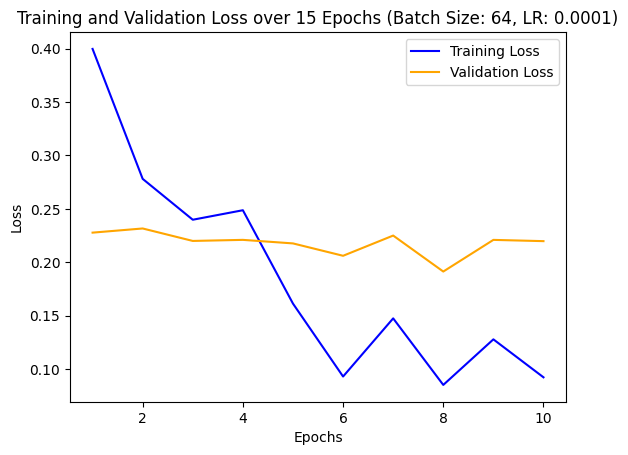

In [9]:
# Plot training loss
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", color="orange")
plt.title(f"Training and Validation Loss over {CFG.n_epochs} Epochs (Batch Size: {CFG.batch_size}, LR: {CFG.lr})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()